# Plots of Average Cloud Fraction

We use the stacked plotting function developed for North Atlantic study.

In [1]:
%matplotlib inline

import glob, os
import numpy as np
import pylab as pl
import seaborn as sns
sns.set_context('talk')
import xarray as xr
import datetime


#pl.rcParams['figure.figsize'] = (16.0, 12.0)
#pl.rcParams['font.size'] = 16.0
#pl.rcParams['axes.labelpad'] = 12

In [2]:

from tropy.standard_config import local_data_path


## Make a Filelist

In [3]:
version = 'v2019-10-18'
# version = 'v2020-02-13'

In [4]:
# old path
fdir = '%s/icon/hdcp2_atlantic_stochconv_main_experiments' % local_data_path

In [5]:
# new path
fdir = '%s/icon/stoch_exp_%s' % ( local_data_path, version )

In [6]:
flist = sorted( glob.glob( '%s/afrac*-hdcp2_atlantic*nc' % fdir) )

In [7]:
for i, fname in enumerate( flist ):
    print(i, fname )

(0, '/vols/fs1/store/senf/data/icon/stoch_exp_v2019-10-18/afrac-stats_msevi-hdcp2_atlantic-20131220.nc')
(1, '/vols/fs1/store/senf/data/icon/stoch_exp_v2019-10-18/afrac-stats_synsat-hdcp2_atlantic_detconv.nc')
(2, '/vols/fs1/store/senf/data/icon/stoch_exp_v2019-10-18/afrac-stats_synsat-hdcp2_atlantic_noconv.nc')
(3, '/vols/fs1/store/senf/data/icon/stoch_exp_v2019-10-18/afrac-stats_synsat-hdcp2_atlantic_stochconv_noconvprec_notundepth.nc')
(4, '/vols/fs1/store/senf/data/icon/stoch_exp_v2019-10-18/afrac-stats_synsat-hdcp2_atlantic_stochconv_vervel_-00.nc')


## Sort Exp a bit

In [8]:
ilist = [0, 2, 1, 3, 4 ]
sorted_fnames = np.array(flist )[ilist]

In [9]:
labels = ['SEVIRI', 'NOCONV', 'D-OPER', 'S-DFLT', 'S-CPLN']

In [10]:
labelmap = {}
for i, fname in enumerate( sorted_fnames ):
    labelmap[fname] = labels[i]
    
    print( '%s %s' % (labels[i], fname))

SEVIRI /vols/fs1/store/senf/data/icon/stoch_exp_v2019-10-18/afrac-stats_msevi-hdcp2_atlantic-20131220.nc
NOCONV /vols/fs1/store/senf/data/icon/stoch_exp_v2019-10-18/afrac-stats_synsat-hdcp2_atlantic_noconv.nc
D-OPER /vols/fs1/store/senf/data/icon/stoch_exp_v2019-10-18/afrac-stats_synsat-hdcp2_atlantic_detconv.nc
S-DFLT /vols/fs1/store/senf/data/icon/stoch_exp_v2019-10-18/afrac-stats_synsat-hdcp2_atlantic_stochconv_noconvprec_notundepth.nc
S-CPLN /vols/fs1/store/senf/data/icon/stoch_exp_v2019-10-18/afrac-stats_synsat-hdcp2_atlantic_stochconv_vervel_-00.nc


## Read Data 

In [11]:
dlist = []

for fname in flist:
    label = labelmap[fname]
    d = xr.open_dataset( fname )
    
    d.expand_dims( 'idname' )
    d['idname'] = [label,]
    
    dlist += [d, ]

In [12]:
dset = xr.concat( dlist, dim = 'idname' )

## Get Rid of Spinup

Let's say we consider the first six hours as spinup.

In [13]:
time_range = slice( '2013-12-20T06', '2013-12-20')

In [14]:
afrac = dset.sel( time = time_range )

## Preparing Variables

### Combine Fractional and Very Low

In [15]:
add_dset = afrac.sel(ct = 'very low') + afrac.sel(ct = 'fractional')
add_dset = add_dset.expand_dims('ct')
add_dset['ct'] = ['very low / fractional']

afrac = xr.concat( [afrac, add_dset], dim = 'ct' )

### Rename CT labels


In [16]:
ctnames = afrac.ct.data
print(ctnames)

['clear_ocean' 'very low' 'low' 'middle' 'high opaque' 'very high opaque'
 'semi. thin' 'semi. meanly thick' 'semi. thick' 'semi. above'
 'fractional' 'very low / fractional']


In [17]:
ctnames == 'semi. meanly thick'

array([False, False, False, False, False, False, False,  True, False,
       False, False, False])

In [18]:
name_map = {'semi. meanly thick' : 'semi. moderately thick', 'middle' : 'mid-level'}

for old_name in name_map.keys():
    new_name = name_map[old_name]
    
    m = ctnames == old_name
    ctnames[m] = new_name

### Total Cloud Fraction 

In [19]:
cc = 100 - afrac.sel(ct = 'clear_ocean')['afrac']

### Average CT Coverages 

In [20]:
catlist = list( afrac.ct.data )

remove_list = ['clear_ocean', 'semi. above', 'very low', 'fractional']

for rm_cat in remove_list:
    catlist.remove(rm_cat)


afrac_cleaned = afrac.sel(ct = catlist )

afrac_ave = afrac_cleaned.mean( 'time' )
afrac_sem = 2 * afrac_cleaned.std( 'time' ) / np.sqrt( afrac_cleaned.count( 'time'))

## Patches 

We like to use the plotting functions developed for `nawdex_analysis`, but they are highly adjusted to the North Atlantic dataset. We use patching to overwrite some functions!

In [21]:
import nawdex_analysis.plot.stacked_analysis_plots
reload( nawdex_analysis.plot.stacked_analysis_plots )

<module 'nawdex_analysis.plot.stacked_analysis_plots' from '/vols/fs1/store/senf/.conda/python27mod/lib/python2.7/site-packages/nawdex_analysis/plot/stacked_analysis_plots.pyc'>

In [22]:
dir(nawdex_analysis.plot.stacked_analysis_plots)

['__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'abc',
 'collector',
 'get_exp_kws',
 'get_exp_kws_bars',
 'get_plotting_order',
 'hor_barplot_exp_plot',
 'hor_flamingo_plots',
 'np',
 'os',
 'pl',
 'plot_net_cre_contrib4set',
 'plot_scre_lcre4set',
 'round2day',
 'sns',
 'stacker4flamingo',
 'string',
 'sys',
 'vert_stacked_exp_plot',
 'xr']

In [23]:
def get_plotting_order( vlist ):
    
    nlen = len( vlist )
    
    return np.array([2,1,0,3,4])

In [38]:
def get_exp_kws( expname, **kwargs ):
    
    ptype = kwargs.get('ptype', 'points')
    
    kws = {}
    labels = ('NOCONV','D-OPER','S-DFLT','S-CPLN')
    cols = ('#0000FF', '#008000', '#FFA500', '#FF0000')
    #cols = [(0.0, 0.0, 1.0), (0.0, 0.5019607843137255, 0.0), 
    #        (1.0, 0.6470588235294118, 0.0), (1.0, 0.0, 0.0)]
    
    for i, lab in enumerate( labels ):
        if expname == lab:
            kws['color'] = cols[i]

    if expname == 'SEVIRI':
        kws['color'] = 'black'
    
    if ptype == 'points' and expname == 'SEVIRI':
        kws['marker'] = 'D'
        kws['zorder'] = 10
        kws['markersize'] = 10
    elif ptype == 'points':
        kws['marker'] = 'o'
        kws['zorder'] = 8
        kws['markersize'] = 8
            
    elif ptype == 'lines':
        kws['lw'] = 3

    return kws


In [39]:
# here we do the patching !

nawdex_analysis.plot.stacked_analysis_plots.get_exp_kws = get_exp_kws
nawdex_analysis.plot.stacked_analysis_plots.get_plotting_order = get_plotting_order


## Plotting 

In [40]:
def plegend(bbox = (1.5, 0.5)):
    handles, labels = pl.gca().get_legend_handles_labels()

    # put msevi on top
    order = range(len(labels))
    mindex = labels.index( 'SEVIRI')
    order.remove(mindex)
    order = [mindex,] + order

    pl.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
          loc='center right', bbox_to_anchor = bbox, fontsize = 'x-large', frameon = False )

### Vertical Stacks 

In [41]:
print( afrac_ave.ct.data )
ctlist = ['very low / fractional', 'low', 'mid-level', 'high opaque', 'very high opaque', 'semi. thin',
       'semi. moderately thick', 'semi. thick', ]

['low' 'mid-level' 'high opaque' 'very high opaque' 'semi. thin'
 'semi. moderately thick' 'semi. thick' 'very low / fractional']


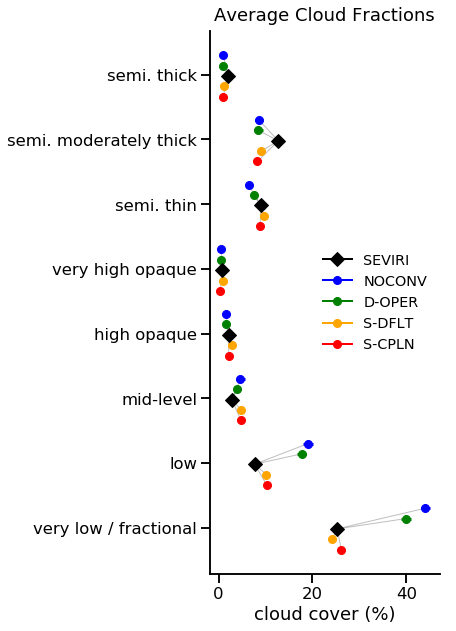

In [42]:
fig,ax  = pl.subplots( ncols = 1, figsize = (8, 10), )

pl.sca(ax)
nawdex_analysis.plot.stacked_analysis_plots.vert_stacked_exp_plot(afrac_ave, 'afrac',
                                                                  var_err = afrac_sem, 
                                                                  catlist = ctlist,  
                                                                  offset0 = 0.3,
                                                                  doffset = -0.16,
                                                                  obsref_name = 'SEVIRI')
pl.xlabel( 'cloud cover (%)')
pl.title('Average Cloud Fractions', pad = 10)
plegend(bbox = (1,0.5))

sns.despine(ax = ax)
pl.subplots_adjust( left = 0.5)
pl.savefig('../pics/ave-cc-comparison_%s.jpg' % version, dpi = 300)


## CC time series

In [29]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%H')    

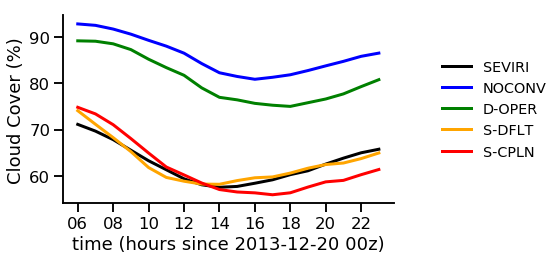

In [43]:
pl.figure( figsize = (8,4.5))

for lab in labels:
    kws = get_exp_kws(lab, ptype = 'lines')
    pl.plot(cc.time, cc.sel(idname = lab), label = lab, **kws)
    
pl.xlabel('time (hours since 2013-12-20 00z)')
pl.ylabel('Cloud Cover (%)')
plegend()
sns.despine()
pl.subplots_adjust( right = 0.7, bottom = 0.3)
pl.gca().xaxis.set_major_formatter(myFmt)
pl.savefig('../pics/cc-tseries-comparison_%s.jpg' % version, dpi = 300)
